# Task Specific MSPM Model Fine-Tuning (Optional)

The stage is optional for
MolPMoFiT. For QSAR tasks, the target datasets may have a distribution different from ChEMBL
dataset (e.g., toxicity data, drug activity data). In this stage, the goal is to fine-tuning the general
domain MSPM on the target QSAR datasets to create the task-specific (endpoint-specific) MSPM. 

**The experiments on BBBP and HIV datasets shown the task-specific MSPM fine-tuning was not beneficial for the model performance.**

The notebook presents an example of fine-tuning the general-domain MSPM on **BBBP** dataset.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') # switch off RDKit warning messages

from sklearn.model_selection import train_test_split

from fastai import *
from fastai.text import *
from utils import *

torch.cuda.set_device(1) #change to 0 if you only has one GPU 

RDKit WARNING: [13:43:09] Enabling RDKit 2019.09.3 jupyter extensions


Create a path to save results.

Load the data.

In [2]:
bbbp_data = pd.read_csv('../data/QSAR/bbbp.csv')
print('Dataset:', bbbp_data.shape)
bbbp_data.head(1)

Dataset: (2039, 2)


,smiles,p_np
0,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,1


## Data Augmentation
Similar to training the general domain MSPM, we use randomized SMILES to augment the data. Since the dataset is small, we generated as much as 100 SMILES for each molecule.

In [3]:
def lm_smiles_augmentation(df, N_rounds):
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
            dist_aug['p_np'].append(df.iloc[i]['p_np'])
    df_aug = pd.DataFrame.from_dict(dist_aug)
    df_aug = df_aug.append(df, ignore_index=True)
    return df_aug.drop_duplicates('smiles')

Random split the data into training and validation sets. **Note: this split is for training the structure prediction model not the QSAR model.**

In [4]:
bbbp_train , bbbp_val = train_test_split(bbbp_data, test_size=0.05, random_state=42)

In [5]:
%%time
bbbp_train_aug = lm_smiles_augmentation(bbbp_train, 100)
bbbp_val_aug = lm_smiles_augmentation(bbbp_val, 100)
print(bbbp_train.shape , bbbp_val.shape)

(1937, 2) (102, 2)
CPU times: user 2min 26s, sys: 268 ms, total: 2min 26s
Wall time: 2min 26s


In [6]:
bbbp_train_aug.shape, bbbp_val_aug.shape

((141588, 2), (7337, 2))

## Prepare data for modeling

Create a path to save the resluts.

In [7]:
result_path = Path('../results')
name = 'BBBP'
path = result_path/name
path.mkdir(exist_ok=True, parents=True)

Model_path = path/'models'
Model_path.mkdir(exist_ok=True, parents=True)

In [8]:
bs = 128
tok = Tokenizer(partial(MolTokenizer, special_tokens = special_tokens), n_cpus=6, pre_rules=[], post_rules=[])

In [9]:
%%time
lm_data = TextLMDataBunch.from_df(path, bbbp_train_aug, bbbp_val_aug, bs=bs, tokenizer=tok, 
                              chunksize=50000, text_cols=0,label_cols=1, max_vocab=60000, include_bos=False)

CPU times: user 2.56 s, sys: 364 ms, total: 2.92 s
Wall time: 3.62 s


## Fine-tuning the General Domain MSPM on BBBP Data


In [22]:
pretrained_model_path = Path('../results/MSPM/models')

pretrained_fnames = ['MSPM_wt', 'MSPM_vocab']
fnames = [pretrained_model_path/f'{fn}.{ext}' for fn,ext in zip(pretrained_fnames, ['pth', 'pkl'])]

Initialize and load the pretrained **weights** to the model.

In [23]:
learner = language_model_learner(lm_data, AWD_LSTM, drop_mult=1.0)
learner = learner.load_pretrained(*fnames)
learner.freeze()

The task specific MSPMs are fine-tuned using
the one cycle policy and discriminative fine-tuning

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 6.31E-02


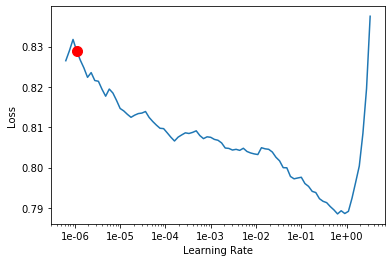

In [24]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [25]:
lr = 1e-3
lr *= bs/48

In [26]:
learner.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.726698,0.688282,0.757419,03:01
1,0.720848,0.685206,0.757801,03:04


In [27]:
learner.unfreeze()
learner.fit_one_cycle(4, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.558040,0.580320,0.794699,04:25
1,0.471014,0.582579,0.800380,04:27
2,0.436315,0.588070,0.802369,04:29
3,0.423084,0.591576,0.803203,04:31


Save the model and the encoder.

In [28]:
learner.save(f'{name}_MSPM_finetuned')
learner.save_encoder(f'{name}_MSPM_finetuned_enc')

# Fine-Tuning the Task-Specific on the QSAR Task

## Load Data

We benchmarked our MolPMoFiT method to other published models from [Yang et al](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00237) on
three well-studied datasets: **lipophilicity**, **HIV** and **BBBP**. All the models were evaluated on the
same ten 80:10:10 [splits](https://github.com/swansonk14/chemprop/blob/master/splits.tar.gz) from Yang et al to ensure a fair and reproducible benchmark.

In [10]:
# Change the split type and id to nagivate different splits.
dataset = 'bbbp'
split_type = 'random'
split_id = 11

split_file = f'{dataset}/{split_type}/split_indices{split_id}.pckl'

with open(f'../data/QSAR/splits/{split_file}', 'rb') as f:
    split = pickle.load(f)
    
print('Train Set:', len(split[0]))
print('Valid Set:', len(split[1]))
print('Test Set:', len(split[2]))

Train Set: 1631
Valid Set: 204
Test Set: 204


In [11]:
train = bbbp_data.iloc[split[0]]
valid = bbbp_data.iloc[split[1]]
test = bbbp_data.iloc[split[2]]
print('Positive Sample:',np.sum(train.p_np == 1), np.sum(valid.p_np == 1), np.sum(test.p_np == 1))

Positive Sample: 1259 151 150


## Data Augmentation

In [12]:
def bbbp_smiles_augmentation(df, N_rounds):
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        if df.iloc[i].p_np == 1:
            for j in range(N_rounds[0]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 0:
            for j in range(N_rounds[1]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])
        
    df_aug = pd.DataFrame.from_dict(dist_aug)
    df_aug = df_aug.append(df, ignore_index=True)
    return df_aug.drop_duplicates('smiles')

As shown above, the dataset is not balanced. For training data, we generated 10 and 30 randomized SMILES for molecules belong to the positive and negative classes, respectively. The numbers can be changed based on different datasets.

In [13]:
train_aug = bbbp_smiles_augmentation(train, [10,30])
valid_aug = bbbp_smiles_augmentation(valid, [5,5])

print('Train_aug Samples:', train_aug.shape[0])
print('Positive:Negative',np.sum(train_aug.p_np == 1)/ np.sum(train_aug.p_np == 0))

print('Valid_aug Samples:', valid_aug.shape[0])
print('Positive:Negative',np.sum(valid_aug.p_np == 1)/ np.sum(valid_aug.p_np == 0))

Train_aug Samples: 23846
Positive:Negative 1.1953599705394955
Valid_aug Samples: 1197
Positive:Negative 2.8


## Build a databunch for QSAR Modeling
You need to change the `text_cols` and `label_col` based on your dataset.

In [14]:
data_db = TextClasDataBunch.from_df(path, train_aug, valid_aug, bs=bs, tokenizer=tok, 
                                          chunksize=50000, text_cols='smiles',label_cols='p_np', 
                                          vocab=lm_data.vocab, max_vocab=60000, include_bos=False)

## Fine-tuning

After initializing the classification model, we load the `weights` of the task-specific MSPM. 

In [15]:
cls_learner = text_classifier_learner(data_db, AWD_LSTM, pretrained=False, drop_mult=0.2, callback_fns=AUROC)
cls_learner.load_encoder(f'{name}_MSPM_finetuned_enc')
cls_learner.freeze()

In [16]:
cls_learner.fit_one_cycle(4, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.452668,0.458218,0.832916,0.872584,00:19
1,0.343069,0.344495,0.866332,0.910301,00:21
2,0.282763,0.382733,0.849624,0.915027,00:19
3,0.205576,0.404516,0.873851,0.913569,00:20


In [17]:
cls_learner.freeze_to(-2)
cls_learner.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.211748,0.425382,0.863826,0.912677,00:24
1,0.149920,0.445971,0.875522,0.919364,00:25
2,0.087477,0.483333,0.891395,0.922165,00:26
3,0.088647,0.492840,0.883876,0.916854,00:24


In [18]:
cls_learner.freeze_to(-3)
cls_learner.fit_one_cycle(4, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.073182,0.492970,0.884712,0.916575,00:41
1,0.067346,0.526776,0.889724,0.919409,00:43
2,0.065800,0.516989,0.885547,0.918153,00:42
3,0.064950,0.508641,0.887218,0.917147,00:40


In [19]:
cls_learner.unfreeze()
cls_learner.fit_one_cycle(6, slice(5e-5/(2.6**4),5e-5), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.075631,0.534999,0.887218,0.920435,00:50
1,0.074448,0.529544,0.878864,0.919649,00:51
2,0.057246,0.492252,0.888889,0.921961,00:55
3,0.068655,0.516799,0.885547,0.919024,00:51
4,0.053387,0.493865,0.887218,0.921245,00:53
5,0.060910,0.505420,0.883876,0.919749,00:58


Save the model.

In [21]:
cls_learner.save(f'{split_type}_{split_id}_clas_lmfinetuned')

## Test on the Test Set

1. Test only on Canoicial SMILES

In [22]:
test_data_db = TextClasDataBunch.from_df(path, train, test, bs=bs, tokenizer=tok, 
                              chunksize=50000, text_cols='smiles',label_cols='p_np', vocab=lm_data.vocab, max_vocab=60000,
                                              include_bos=False)

learner = text_classifier_learner(test_data_db, AWD_LSTM, pretrained=False, drop_mult=0.2)
learner.load(f'{split_type}_{split_id}_clas_lmfinetuned', purge=False);

test_get_scores(learner)

Testing 204 molecues
Accuracy: 0.907
False Positives: 0.074
False Negatives: 0.020
Recall: 0.973
Precision: 0.907
Sensitivity: 0.973
Specificity: 0.722
MCC: 0.752
ROCAUC: 0.948


2. Test on averaging prediction of canoicial and randomized SMILES.

In [24]:
def test_smiles_augmentation(df):
    dist_aug = {col_name: [] for col_name in df}
    
    for i in range(df.shape[0]):
        dist_aug['smiles'].append(randomize_smiles(df.iloc[i]['smiles']))
        dist_aug['p_np'].append(df.iloc[i]['p_np'])
                     
    return pd.DataFrame.from_dict(dist_aug)

In [26]:
preds = []

# Randomized SMILES Predictions
for i in range(4):
    np.random.seed(12*i)    
    test_aug = test_smiles_augmentation(test)
    
    # model
    test_data_db = TextClasDataBunch.from_df(path, train, test_aug, bs=bs, tokenizer=tok, 
                              chunksize=50000, text_cols='smiles',label_cols='p_np', vocab=lm_data.vocab, max_vocab=60000,
                                              include_bos=False)
    learner = text_classifier_learner(test_data_db, AWD_LSTM, pretrained=False, drop_mult=0.2)
    learner.load(f'{split_type}_{split_id}_clas_lmfinetuned', purge=False);
    
    
    #get predictions
    pred,lbl = learner.get_preds(ordered=True)
    
    preds.append(pred)

# Canonical SMILES Predictions

test_data_db = TextClasDataBunch.from_df(path, train, test, bs=bs, tokenizer=tok, 
                              chunksize=50000, text_cols='smiles',label_cols='p_np', vocab=lm_data.vocab, max_vocab=60000,
                                              include_bos=False)

learner = text_classifier_learner(test_data_db, AWD_LSTM, pretrained=False, drop_mult=0.2)
learner.load(f'{split_type}_{split_id}_clas_lmfinetuned', purge=False);


pred,lbl = learner.get_preds(ordered=True)


preds.append(pred)



In [27]:
avg_preds = sum(preds)/len(preds)
print(f'Performance of Averaging Predictions of Canoicial and Randomized SMILES: {roc_auc_score(lbl, avg_preds[:,1]):.3f}')

Performance of Averaging Predictions of Canoicial and Randomized SMILES: 0.930
